<a href="https://colab.research.google.com/github/ml2-project-team/omar-version/blob/main/step1_mall%2Bkmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mall Customer Dataset

In [1]:
!pip install kneed

In [2]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 5.0 MB/s eta 0:00:00


In [3]:
!pip install imbalanced-learn

In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler,PowerTransformer,QuantileTransformer
import kagglehub
import os
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans,MiniBatchKMeans,DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter
from kneed import KneeLocator
import time
import psutil
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import OneClassSVM
from category_encoders import BinaryEncoder

# Load Data

In [5]:
path = kagglehub.dataset_download("vjchoudhary7/customer-segmentation-tutorial-in-python")
csv_path = os.path.join(path, "Mall_Customers.csv")
mall_customers = pd.read_csv(csv_path)

In [6]:
mall_customers.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


# Data Overview

In [7]:
mall_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


**All the features is numerical and only the ("Gender") feature is a categorical feature so we need to encode it later...**

In [8]:
#Summary statistics
mall_customers.describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerID,200.0,100.50,57.879185,1.0,50.75,100.5,150.25,200.0
Age,200.0,38.85,13.969007,18.0,28.75,36.0,49.00,70.0
Annual Income (k$),200.0,60.56,26.264721,15.0,41.50,61.5,78.00,137.0
Spending Score (1-100),200.0,50.20,25.823522,1.0,34.75,50.0,73.00,99.0


In [9]:
#check for missing values
print('Missing values:')
mall_customers.isnull().sum()

Missing values:


,0
CustomerID,0
Gender,0
Age,0
Annual Income (k$),0
Spending Score (1-100),0


**The dataset does not contain any missing values**

# Features Distribution

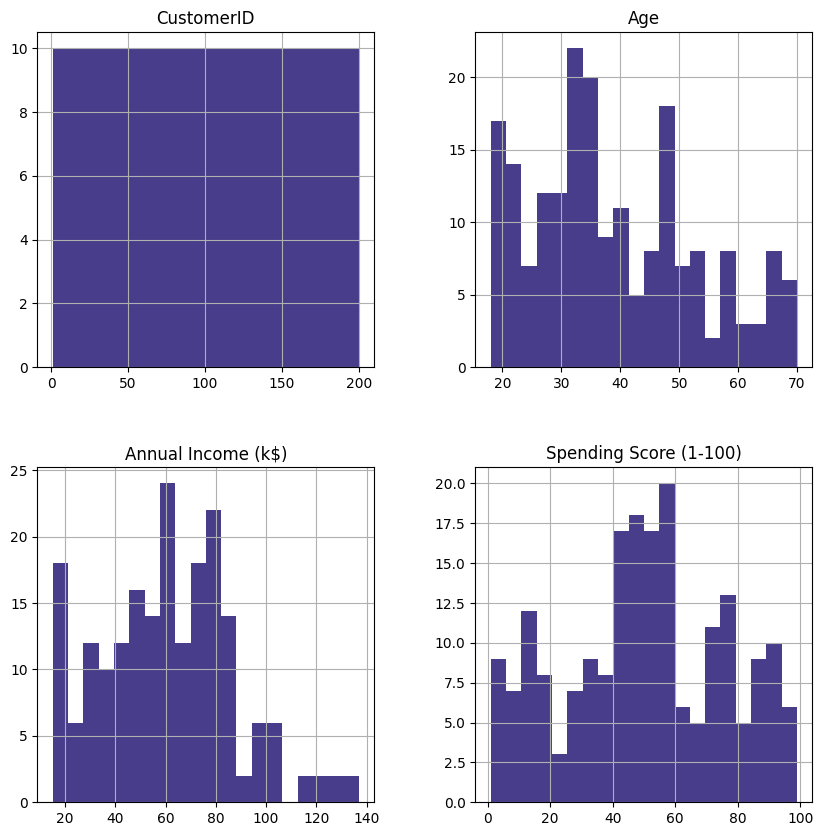

In [10]:
mall_customers.hist(figsize=(10,10),bins=20,color='#483D8B')
plt.show()

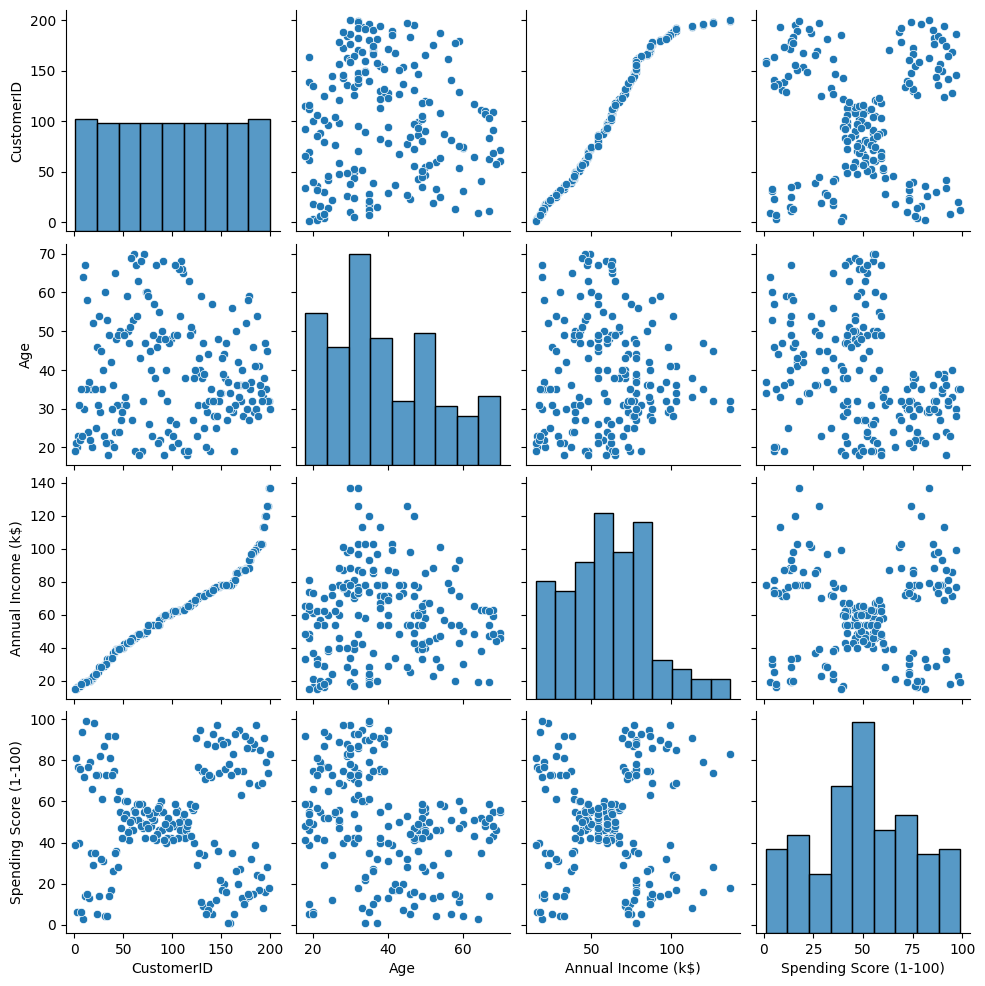

In [11]:
sample = mall_customers.sample(200)
sns.pairplot(sample)
#It plots the correlation between every feature and itself

<Axes: xlabel='Gender', ylabel='Count'>

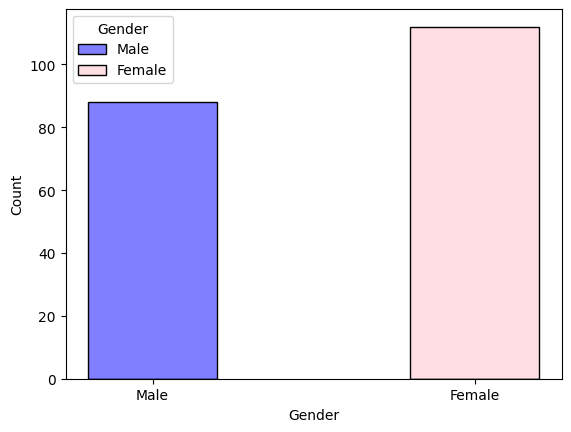

In [12]:
sns.histplot(x='Gender', data=mall_customers, hue='Gender',
             palette=['blue', 'pink'] , shrink = 0.4)
# shrink mean the value size on the x axis

**Here we see that the majority is Female**

Text(0.5, 1.0, 'Age Distribution')

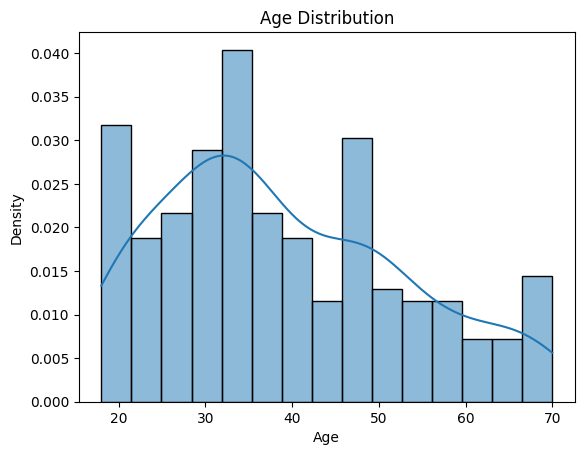

In [13]:
sns.histplot(mall_customers['Age'] , stat='density' , bins =15 , kde=True)
plt.title("Age Distribution")

**The majority here in the Age in range between 30-35 and it's almost uniform distribution**

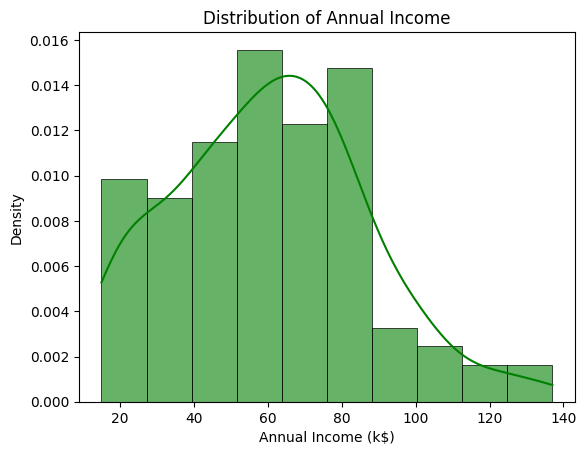

In [14]:
sns.histplot(data=mall_customers,x="Annual Income (k$)",stat="density",kde=True,color="green",alpha=0.6,linewidth=0.5,bins=10)

plt.xlabel('Annual Income (k$)')
plt.ylabel('Density')
plt.title('Distribution of Annual Income')
plt.show()

Text(0, 0.5, 'Density')

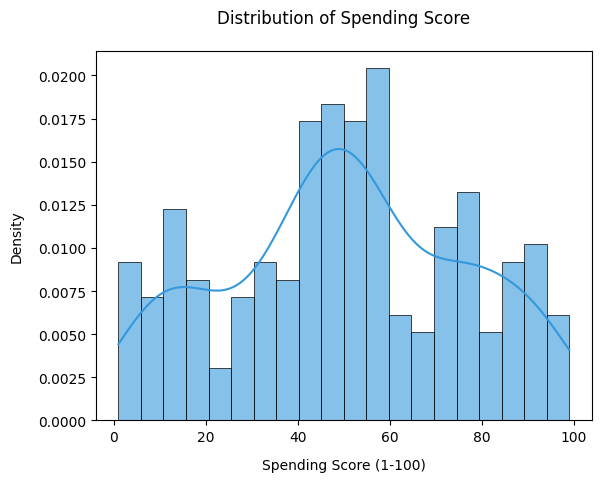

In [15]:
sns.histplot(data=mall_customers,x="Spending Score (1-100)",stat="density",kde=True,color="#3498db",alpha=0.6,linewidth=0.5,bins=20)
plt.title("Distribution of Spending Score", pad=20)
plt.xlabel("Spending Score (1-100)", labelpad=10)
plt.ylabel("Density", labelpad=10)

The peak from 40-60

# Preprocessing

**Encoding our categorical feature ("Gender") using the binary encoder**

In [16]:
encoder = BinaryEncoder(cols=['Gender'])
X_encoded = encoder.fit_transform(mall_customers)
mall_customers = X_encoded

In [17]:
mall_customers

,CustomerID,Gender_0,Gender_1,Age,Annual Income (k$),Spending Score (1-100)
0,1,0,1,19,15,39
1,2,0,1,21,15,81
2,3,1,0,20,16,6
3,4,1,0,23,16,77
4,5,1,0,31,17,40
...,...,...,...,...,...,...
195,196,1,0,35,120,79
196,197,1,0,45,126,28
197,198,0,1,32,126,74
198,199,0,1,32,137,18


**Gender_1 is male **

**We will drop the ("CustomerID") feature because it cannot affect anything at work.**

In [18]:
mall_customers = mall_customers.drop(['CustomerID'], axis=1)

In [19]:
mall_customers

,Gender_0,Gender_1,Age,Annual Income (k$),Spending Score (1-100)
0,0,1,19,15,39
1,0,1,21,15,81
2,1,0,20,16,6
3,1,0,23,16,77
4,1,0,31,17,40
...,...,...,...,...,...
195,1,0,35,120,79
196,1,0,45,126,28
197,0,1,32,126,74
198,0,1,32,137,18


In [20]:
skewed_features = mall_customers.skew().sort_values(ascending=False)
skewed_features

,0
Age,0.485569
Annual Income (k$),0.321843
Gender_1,0.243578
Spending Score (1-100),-0.047220
Gender_0,-0.243578


**All features is approximately symmetric.So no need to fix it**

In [21]:
Q75=mall_customers.quantile(0.75)
Q25=mall_customers.quantile(0.25)
IQR=Q75-Q25
min_point= Q25- IQR*1.5
max_point= Q75+ IQR*1.5
Outliers=((mall_customers<min_point)|(mall_customers>max_point))
print(Outliers.sum())

Gender_0                  0
Gender_1                  0
Age                       0
Annual Income (k$)        2
Spending Score (1-100)    0
dtype: int64


There is no outliers...just 2 datapoints in the ("Annual Income (k$)") so no need to fix it..

In [22]:
threshold = 0.5
FeaturesCorr=mall_customers.corr().abs()
for feature in FeaturesCorr.columns:

    high_corr = FeaturesCorr[feature][(FeaturesCorr[feature] > threshold) & (FeaturesCorr[feature] < 1)].index.tolist()

high_corr

[]

NO features in the dataset have a correlation higher than 0.5 with each other.

Lets see the heatmap to show everything...

Text(0.5, 1.0, 'Correlation Matrix')

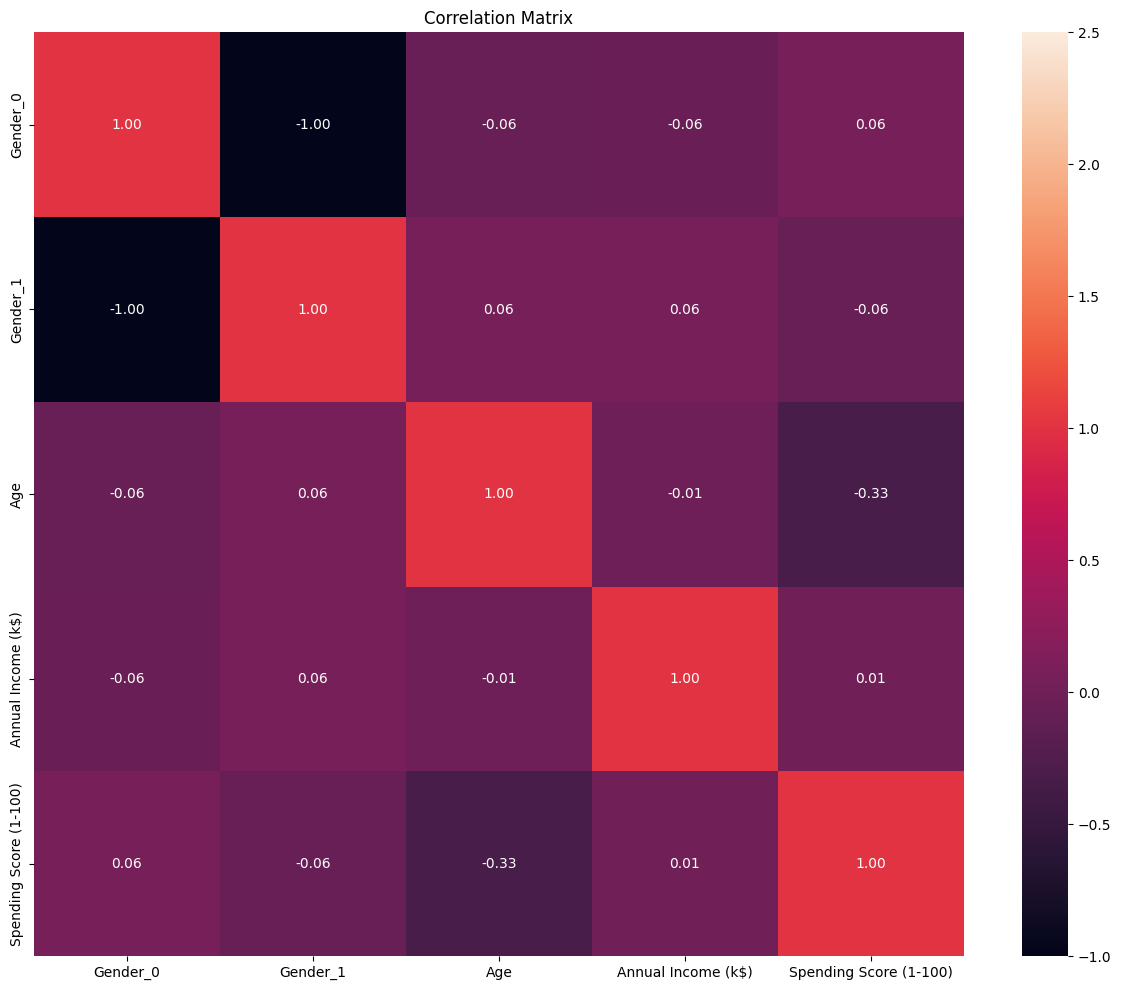

In [23]:
plt.figure(figsize=(15,12))
sns.heatmap(mall_customers.corr(),annot=True,fmt=".2f", vmin=-1, vmax=2.5)
plt.title('Correlation Matrix')

Number of components to retain 90% variance: 4


<ipython-input-24-d77ccd5d444c>:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=pca_df, x='PC1', y='PC2', palette=['#483D8B','#E7F255'], s=100, alpha=0.7, edgecolor='k', marker='o')
<ipython-input-24-d77ccd5d444c>:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Class', fontsize=12)


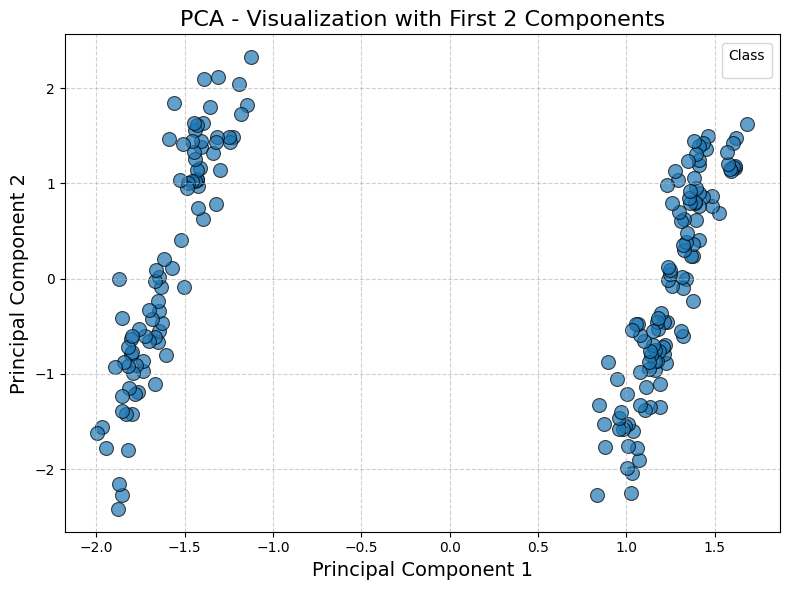

In [24]:
scaler=StandardScaler()
X_scaled=scaler.fit_transform(mall_customers)


pca = PCA(n_components=0.93)
X_pca = pca.fit_transform(X_scaled)
print("Number of components to retain 90% variance:" ,pca.n_components_)
pca_df = pd.DataFrame(data=X_pca, columns=[f'PC{i+1}' for i in range(pca.n_components_)])



plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', palette=['#483D8B','#E7F255'], s=100, alpha=0.7, edgecolor='k', marker='o')
plt.title('PCA - Visualization with First 2 Components', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=14)
plt.ylabel('Principal Component 2', fontsize=14)
plt.legend(title='Class', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



Interpretation
The data can be separated into two clear groups based on their positions in this PCA space.

This indicates that the underlying classes in the original dataset are well-separated when projected into two dimensions.

PCA has successfully preserved the class-discriminative structure in just two dimensions.

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.001s...
[t-SNE] Computed neighbors for 200 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 14.908206
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.770859
[t-SNE] KL divergence after 500 iterations: 0.194863


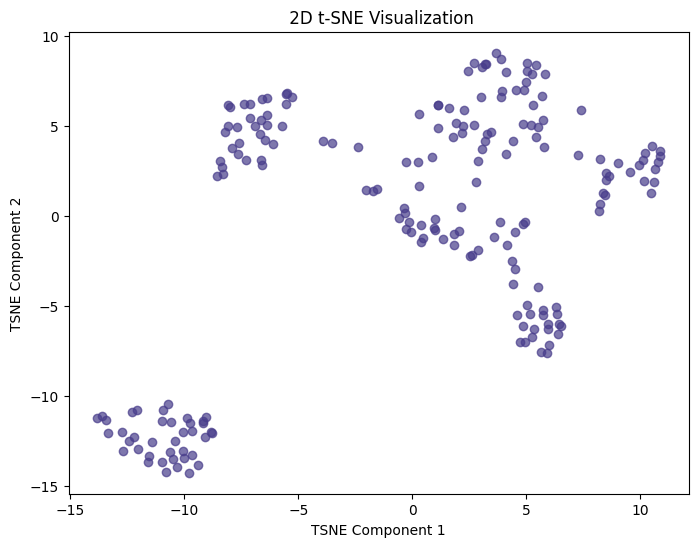

In [29]:
tsne=TSNE(n_components=2,random_state=42,perplexity=30,max_iter=500,verbose=1)
X_tsne=tsne.fit_transform(mall_customers)


plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.7,color='#483D8B')
plt.title(' 2D t-SNE Visualization')
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.show()

In [30]:
tsne_baseline= TSNE(n_components=2, random_state=random_states[0], perplexity=30)
X_baseline= tsne_baseline.fit_transform(X_scaled)
mean_diffs = []
for i in random_states[1:]:
    tsne2=TSNE(n_components=2, random_state=i, perplexity=30)
    X_tsne=tsne2.fit_transform(X_scaled)


    diff = np.mean(np.abs(X_tsne - X_baseline))
    mean_diffs.append((i, diff))

print("Average coordinate difference:")
for state, diff in mean_diffs:
    print(f"Random State = {state}, Mean Difference = {diff:.4f}")


NameError: name 'random_states' is not defined

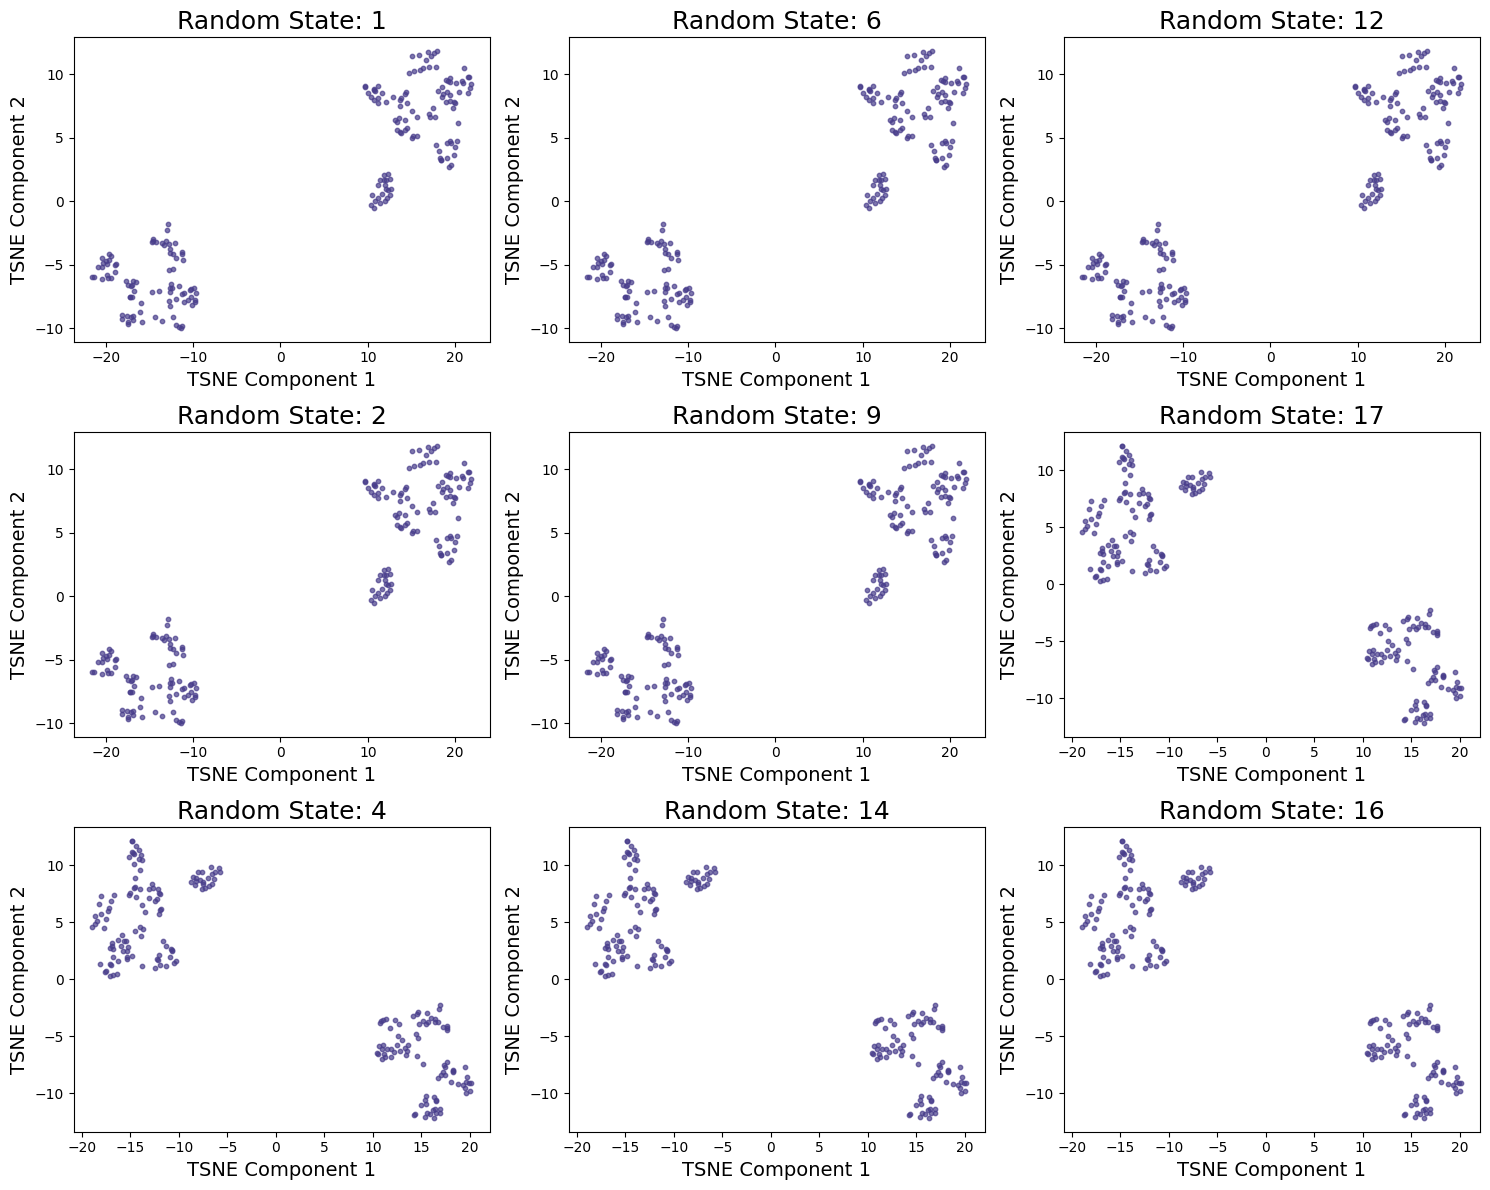

In [31]:
np.random.seed(42)
random_states=np.random.choice(range(1, 20), size=9, replace=False)
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for a,i in enumerate(random_states) :

    tsne1=TSNE(n_components=2, random_state=i, perplexity=30)
    X_train_tsne=tsne1.fit_transform(X_scaled)

    ax=axes[a]
    ax.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], alpha=0.7, color='#483D8B', s=10)
    ax.set_title(f'Random State: {i}', fontsize=18)
    ax.set_xlabel('TSNE Component 1', fontsize=14)
    ax.set_ylabel('TSNE Component 2', fontsize=14)
plt.tight_layout()
plt.show()

Feature Engineering

In [33]:
#chat
mall_customers['Income_per_Age'] = mall_customers['Annual Income (k$)'] / mall_customers['Age']

#chat
mall_customers['SpendingCategory'] = pd.cut(mall_customers['Spending Score (1-100)'],bins=[0, 33, 66, 100],labels=[0,1,2])

#Scaling

In [34]:
scaler=StandardScaler()
X_scaled = scaler.fit_transform(mall_customers)

# PCA

In [35]:
pca = PCA().fit(X_scaled)

In [36]:
eigenvalues=pca.explained_variance_
eigenvalues

array([2.38633618, 2.06717918, 1.63268257, 0.84596909, 0.05431491,
       0.04869394, 0.        ])

pca.explained_variance_ returns the **eigenvalues** corresponding to each principal component. These values represent the **amount of variance** captured by each component in the transformed feature space.

This means:
- The **first principal component** captures 2.38 units of variance from the original data.
- The **second principal component** captures 2.07 units.
- The **third principal component** captures 1.63 units, and so on.

Larger eigenvalues indicate that the component explains more variability in the data. PCA arranges components in decreasing order of these values, so the first components are the most informative. These eigenvalues are also used to compute the explained variance ratio, which helps in selecting the number of components to retain.




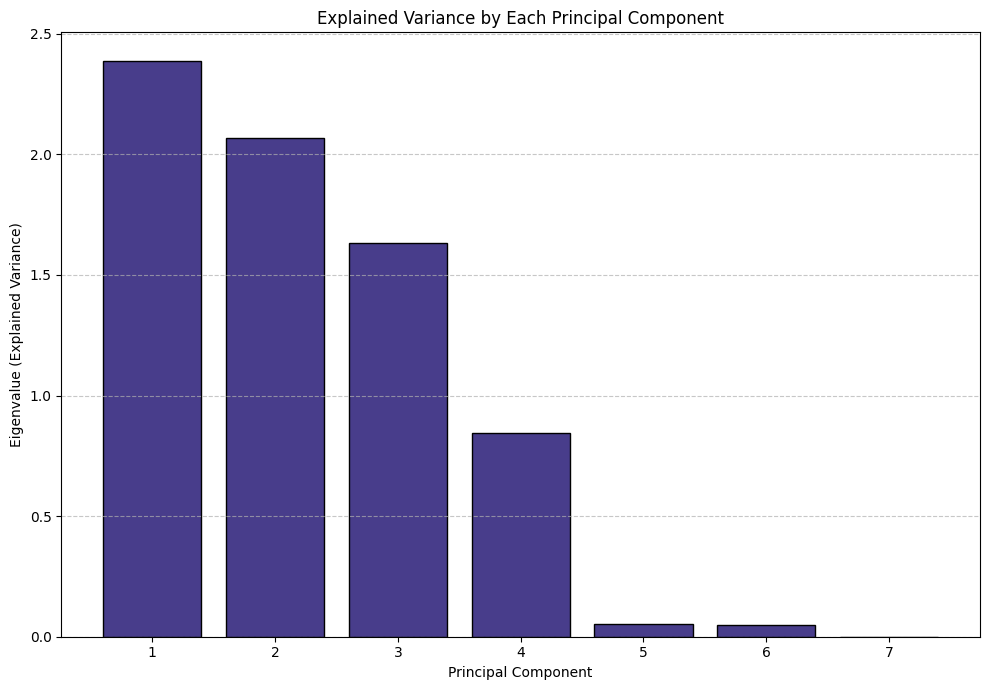

In [37]:
components = np.arange(1, len(eigenvalues) + 1)

plt.figure(figsize=(10, 7))
plt.bar(components, eigenvalues, color='#483D8B', edgecolor='black')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue (Explained Variance)')
plt.title('Explained Variance by Each Principal Component')
plt.xticks(components)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [38]:
cumulativeVariance=np.cumsum(pca.explained_variance_ratio_)#This line calculates the cumulative sum of the variance explained by each principal component in PCA
cumulativeVariance

array([0.33920064, 0.6330354 , 0.86510956, 0.98535803, 0.9930785 ,
       1.        , 1.        ])

The goal is to calculate the total variance explained by the first n principal components, helping decide how many components are needed to capture a desired percentage of the total variance.

In [39]:
n_components=np.argmax(cumulativeVariance>=0.93)+1 #Determines the number of principal components needed to retain at least 93% of the cumulative variance in PCA
print('The number of principal component is:' ,n_components)

The number of principal component is: 4


In [40]:
plt.figure(figsize=(10,6))
fig = go.Figure()
#cumulative variance plot
fig.add_trace(go.Scatter(x=list(range(1, len(cumulativeVariance) + 1)),
                         y=cumulativeVariance,
                         mode='markers+lines',
                         name='Cumulative Variance',
                         marker=dict(color='#483D8B')
                        ))

# Add the 95% threshold line
fig.add_trace(go.Scatter(x=[1, len(cumulativeVariance)],
                         y=[0.93, 0.93],
                         mode='lines',
                         name='93% Threshold',
                         line=dict(dash='dash'),
                         marker=dict(color='#E7F255')
                        ))


fig.update_layout(
    title="Cumulative Variance vs Number of Principal Components",
    xaxis_title="Number of Principal Components",
    yaxis_title="Cumulative Variance Percentage",
    template="plotly_dark",
    showlegend=True
)

fig.show()

<Figure size 1000x600 with 0 Axes>

In [41]:
print(X_scaled.shape)

(200, 7)


In [42]:
pca2=PCA(n_components=n_components)
X_train_pca=pca2.fit_transform(X_scaled)

In [43]:
print(X_train_pca.shape)

(200, 4)


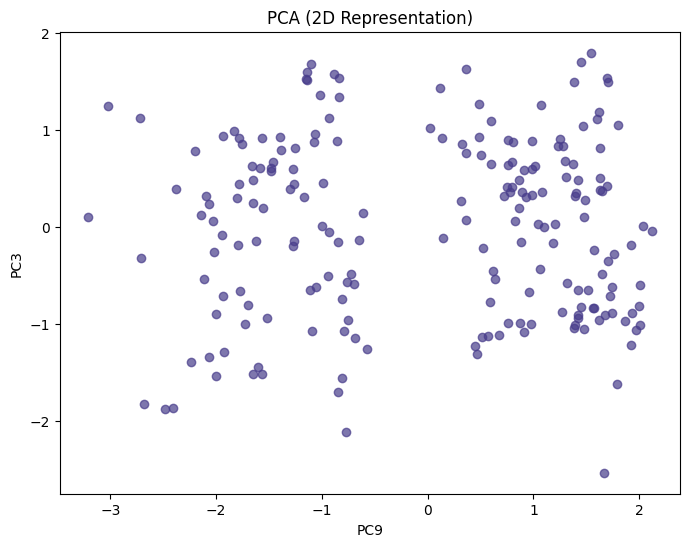

In [44]:
plt.figure(figsize=(8,6))
plt.scatter(X_train_pca[:,1], X_train_pca[:,3], alpha=0.7,color='#483D8B')# the components are chosen randomly
plt.title('PCA (2D Representation)')
plt.xlabel('PC9')
plt.ylabel('PC3')
plt.show()

# TSNE

In [45]:
tsne=TSNE(n_components=1,random_state=42,perplexity=30,max_iter=500,verbose=1)
X_train_tsne=tsne.fit_transform(X_train_pca)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.001s...
[t-SNE] Computed neighbors for 200 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 1.276383
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.265881
[t-SNE] KL divergence after 500 iterations: 0.289376


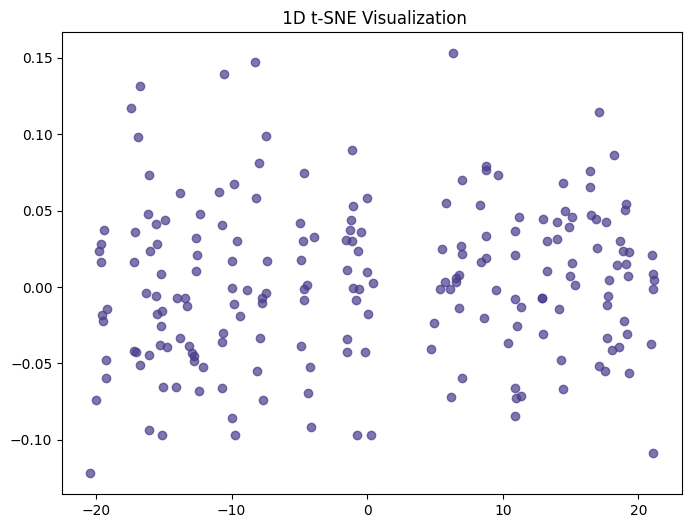

In [46]:
plt.figure(figsize=(8, 6))
j = np.random.normal(0, 0.05, size=X_train_tsne.shape)
plt.scatter(X_train_tsne.flatten(),j.flatten(), alpha=0.7,color='#483D8B')
plt.title(' 1D t-SNE Visualization')
plt.show()

In [47]:
tsne=TSNE(n_components=2,random_state=42,perplexity=30,max_iter=500,verbose=1)
X_train_tsne=tsne.fit_transform(X_train_pca)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.001s...
[t-SNE] Computed neighbors for 200 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 1.276383
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.455170
[t-SNE] KL divergence after 500 iterations: 0.156282


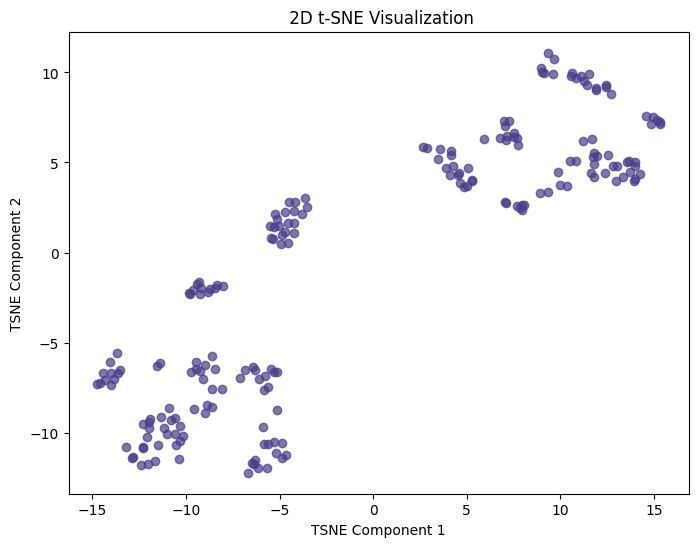

In [48]:
plt.figure(figsize=(8, 6))
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], alpha=0.7,color='#483D8B')
plt.title(' 2D t-SNE Visualization')
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.show()

In [49]:
tsne=TSNE(n_components=3,random_state=42,perplexity=30,max_iter=500,verbose=1)
X_train_tsne=tsne.fit_transform(X_train_pca)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.000s...
[t-SNE] Computed neighbors for 200 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 1.276383
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.364014
[t-SNE] KL divergence after 500 iterations: 0.115719


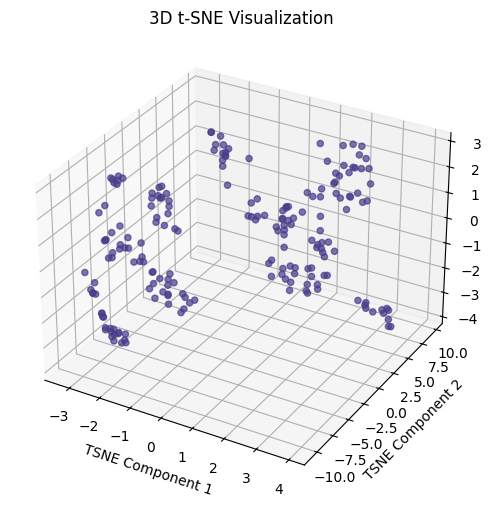

In [50]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], X_train_tsne[:, 2], alpha=0.7,color='#483D8B')
ax.set_title('3D t-SNE Visualization')
ax.set_xlabel('TSNE Component 1')
ax.set_ylabel('TSNE Component 2')
ax.set_zlabel('TSNE Component 3')

plt.show()

# **Kmeans**

In [51]:
def track_memory():
  cu_mem=psutil.Process()
  start_time=time.time()
  return cu_mem,start_time
def print_memory_usage(cu_mem,start_time,model_name):
  end_time=time.time()
  memory_used=cu_mem.memory_info().rss/(1024**2)
  execution_time=end_time-start_time
  return memory_used,execution_time

In [52]:
from sklearn.cluster import KMeans
cu_mem,start_time=track_memory()
kmeans=KMeans(n_clusters=2,random_state=42,init='random')
model_1=kmeans.fit(X_train_pca)
memory_used,execution_time=print_memory_usage(cu_mem,start_time,'model_1')
pridiction=model_1.predict(X_train_pca)


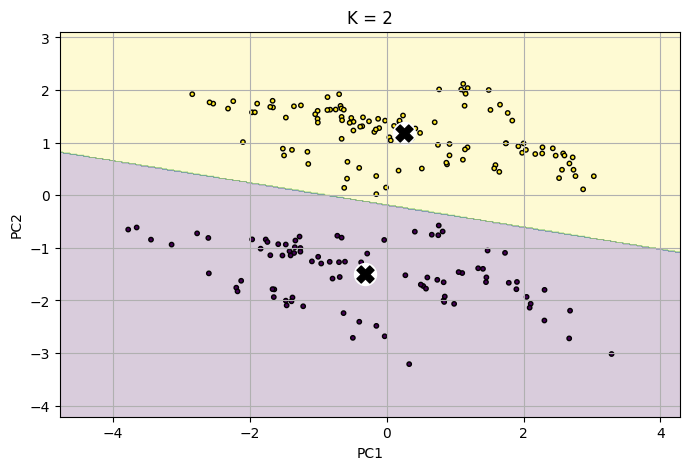

In [53]:
h = 0.02
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
cmap = plt.get_cmap('viridis', 5)

grid = np.zeros((xx.ravel().shape[0], X_train_pca.shape[1]))
grid[:, 0] = xx.ravel()
grid[:, 1] = yy.ravel()

Z = model_1.predict(grid).reshape(xx.shape)
fig,ax=plt.subplots(1,1,figsize=(8,5))
ax.contourf(xx, yy, Z, cmap=cmap, alpha=0.2)
ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=model_1.labels_, cmap=cmap, s=10, edgecolor='k')
ax.scatter(model_1.cluster_centers_[:, 0], model_1.cluster_centers_[:, 1], c='white', marker='o', s=250)
ax.scatter(model_1.cluster_centers_[:, 0], model_1.cluster_centers_[:, 1], c='black', marker='X', s=150)
ax.set_title("K = 2")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.grid()
plt.show()

This plot shows the clustering result obtained using Standard KMeans with K=2,the dataset is partitioned into two clusters,visually represented by distinct colors and separated by a decision boundary ,eacht point's color corresponds to its cluster,
this visual segmentation alone does not confirm the clustering's optimality ,To further evaluate the quality of this clustering, we will now calculate the Inertia and Silhouette Score, which help determine whether this division is meaningful and well-separated.

In [54]:
print("Inertia Value: ",model_1.inertia_)
print("Silhouette Score:",silhouette_score(X_train_pca, pridiction,sample_size=100,random_state=42))

Inertia Value:  976.2066212762138
Silhouette Score: 0.3130106687707073


In [55]:
k_values = range(2,21)
inertia=[]
silhouette_scores={}
models={}

for k in k_values:
  kmeans=KMeans(n_clusters=k,random_state=42,init='random')
  kmeans.fit(X_train_pca)
  inertia.append(kmeans.inertia_)
  silhouette_scores[k]=silhouette_score(X_train_pca,kmeans.labels_,sample_size=10000,random_state=42)
  models[k]=kmeans
kl = KneeLocator(k_values, inertia, curve="convex", direction="decreasing")
best_k = kl.elbow
print("Best k (Elbow Point) = ",best_k)

Best k (Elbow Point) =  8


This cell uses the KneeLocator to identify the best number of clusters by detecting the elbow point based on the inertia curve,it works by analyzing the curve of (number of clusters , inertia ) it detects the point of maximum curvature where the curve bends most sharply


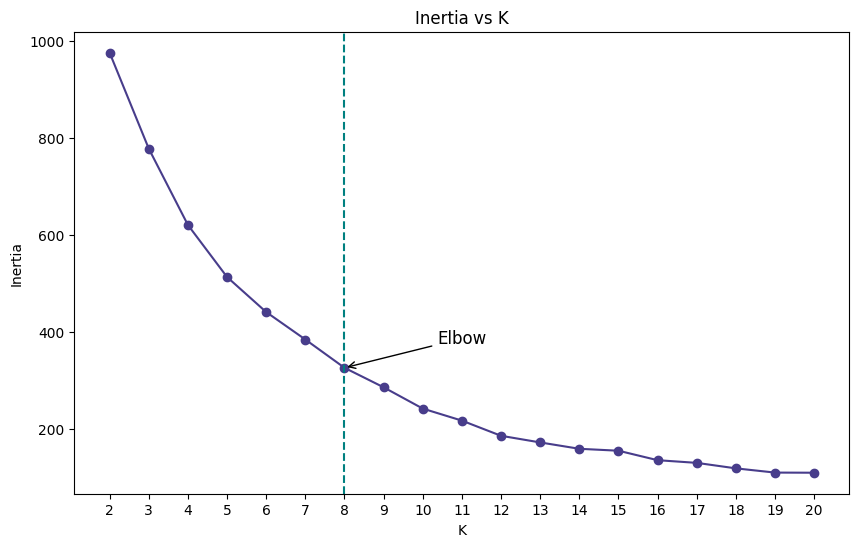

In [56]:
plt.figure(figsize=(10,6))
plt.plot(k_values,inertia,marker='o',color='#483D8B')
plt.title('Inertia vs K')
plt.xlabel('K')
plt.ylabel('Inertia')
plt.xticks(k_values)
elbow_x = best_k
elbow_y = inertia[best_k -2]
plt.axvline(best_k, color='#008080', linestyle='--', label=f"Best k = {best_k}")
plt.annotate("Elbow",
             xy=(elbow_x, elbow_y),
             xytext=(elbow_x + 3, elbow_y+50),
             arrowprops=dict(facecolor='black', arrowstyle="->"),
             fontsize=12,
             ha='center')
plt.show()

In [57]:
best_k = max(silhouette_scores, key=silhouette_scores.get)
print("Best k based on Silhouette Score = ",best_k)

Best k based on Silhouette Score =  13


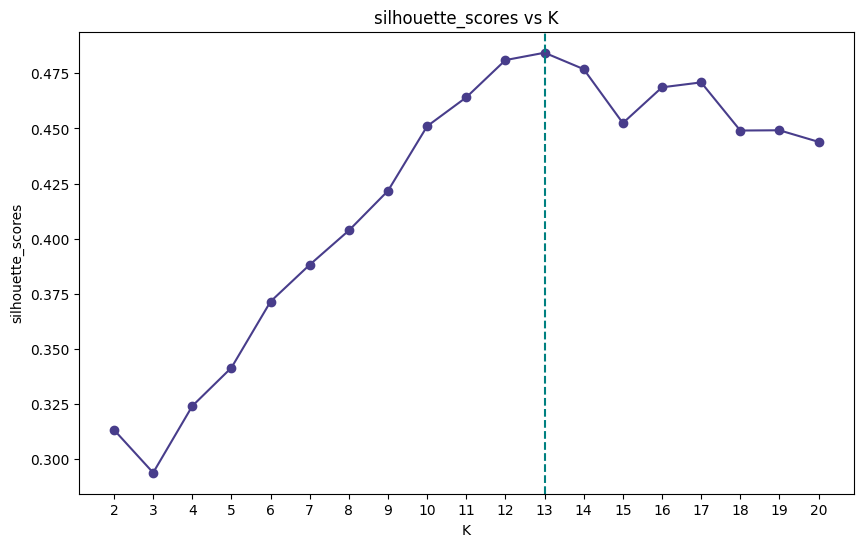

In [58]:
plt.figure(figsize=(10,6))
plt.plot(list(silhouette_scores.keys()),list(silhouette_scores.values()),marker='o',color='#483D8B')
plt.title('silhouette_scores vs K')
plt.xlabel('K')
plt.xticks(k_values)
plt.ylabel('silhouette_scores')
plt.axvline(best_k, color='#008080', linestyle='--', label=f"Best k = {best_k}")
plt.show()

This plot displays the Silhouette Score for different values of K (number of clusters).
The goal is to identify the value of K that yields the highest Silhouette Score, indicating the most well-defined clusters.

In this case, the peak score occurs at K = 13, suggesting that 13 is the optimal number of clusters for this dataset.

Conclusion:
Choosing K = 13 provides the best balance between intra-cluster similarity and inter-cluster separation, leading to better clustering performance.





kmeans++

In [59]:
cu_mem,start_time=track_memory()
model_2=KMeans(n_clusters=best_k,random_state=42,init='k-means++')
model_2.fit(X_train_pca)
memory_usedP,execution_timeP=print_memory_usage(cu_mem,start_time,'model_2')
pridiction_P=model_2.predict(X_train_pca)
print("Execution Time:",execution_time)
print("Memory Usage in MB:",memory_used)

Execution Time: 0.007389068603515625
Memory Usage in MB: 401.9921875


In [60]:
print("Inertia Value: ",model_1.inertia_)
print("Silhouette Score:",silhouette_score(X_train_pca, pridiction,sample_size=10000,random_state=42))

Inertia Value:  976.2066212762138
Silhouette Score: 0.31327974426201555


In [68]:
k_values = range(2,21)
inertia=[]
silhouette_scores={}
models={}

for k in k_values:
  kmeans=KMeans(n_clusters=k,random_state=42,init='k-means++')
  kmeans.fit(X_train_pca)
  inertia.append(kmeans.inertia_)
  silhouette_scores[k]=silhouette_score(X_train_pca,kmeans.labels_,sample_size=10000,random_state=42)
  models[k]=kmeans
kl = KneeLocator(k_values, inertia, curve="convex", direction="decreasing")
best_k = kl.elbow
print("Best k (Elbow Point) = ",best_k)

Best k (Elbow Point) =  8


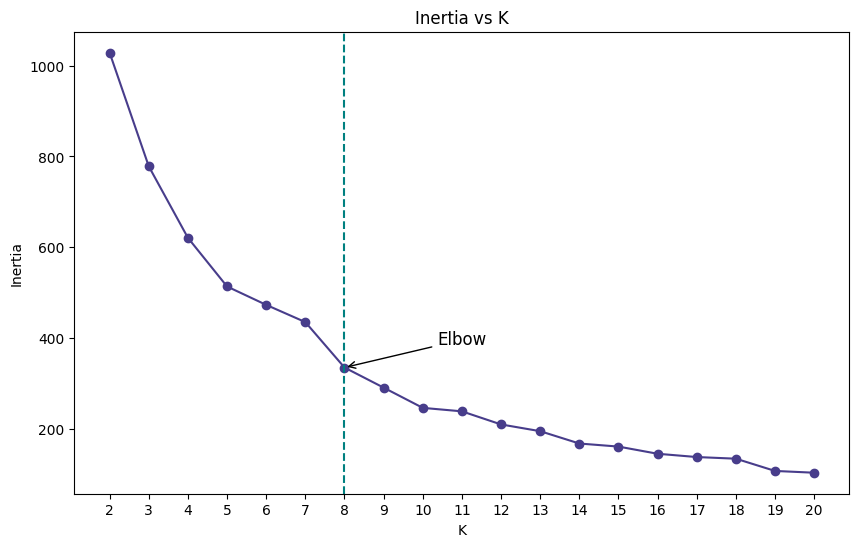

In [69]:
plt.figure(figsize=(10,6))
plt.plot(k_values,inertia,marker='o',color='#483D8B')
plt.title('Inertia vs K')
plt.xlabel('K')
plt.ylabel('Inertia')
plt.xticks(k_values)
elbow_x = best_k
elbow_y = inertia[best_k -2]
plt.axvline(best_k, color='#008080', linestyle='--', label=f"Best k = {best_k}")
plt.annotate("Elbow",
             xy=(elbow_x, elbow_y),
             xytext=(elbow_x + 3, elbow_y+50),
             arrowprops=dict(facecolor='black', arrowstyle="->"),
             fontsize=12,
             ha='center')
plt.show()

In [70]:
best_k = max(silhouette_scores, key=silhouette_scores.get)
print("Best k based on Silhouette Score = ",best_k)

Best k based on Silhouette Score =  19


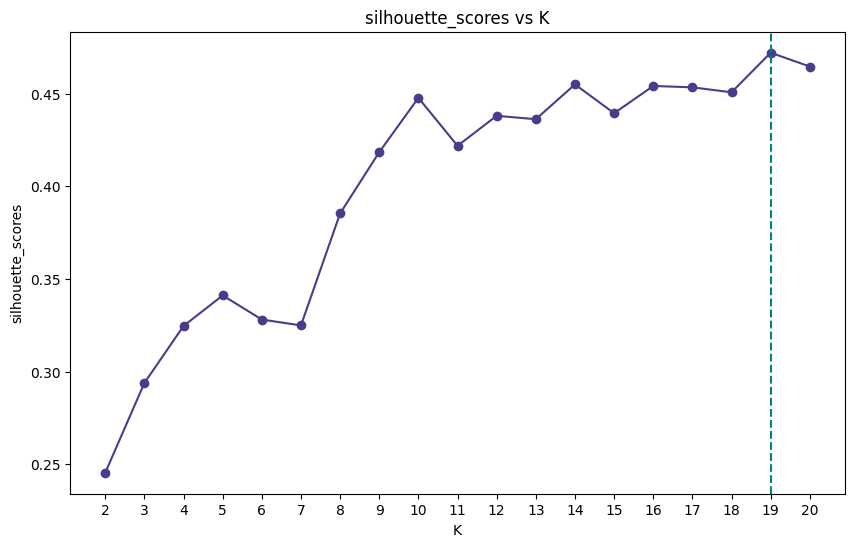

In [71]:
plt.figure(figsize=(10,6))
plt.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()), marker='o',color='#483D8B')
plt.title('silhouette_scores vs K')
plt.xlabel('K')
plt.xticks(k_values)
plt.ylabel('silhouette_scores')
plt.axvline(best_k, color='#008080', linestyle='--', label=f"Best k = {best_k}")
plt.show()

Compare standard KMeans and KMeans++:

In [72]:
SK_VS_KP=pd.DataFrame({'Metric':["Inertia", "Silhouette Score","Iterations","Execution Time"],
          'Standard KMeans':[model_1.inertia_,silhouette_score(X_train_pca, pridiction,sample_size=15000,random_state=42),model_1.n_iter_,execution_time],
          'KMeans Plus Plus':[model_2.inertia_,silhouette_score(X_train_pca, pridiction_P,sample_size=15000,random_state=42),model_2.n_iter_,execution_timeP]})
SK_VS_KP

,Metric,Standard KMeans,KMeans Plus Plus
0,Inertia,976.206621,194.158226
1,Silhouette Score,0.313280,0.436200
2,Iterations,2.000000,3.000000
3,Execution Time,0.007389,0.004766


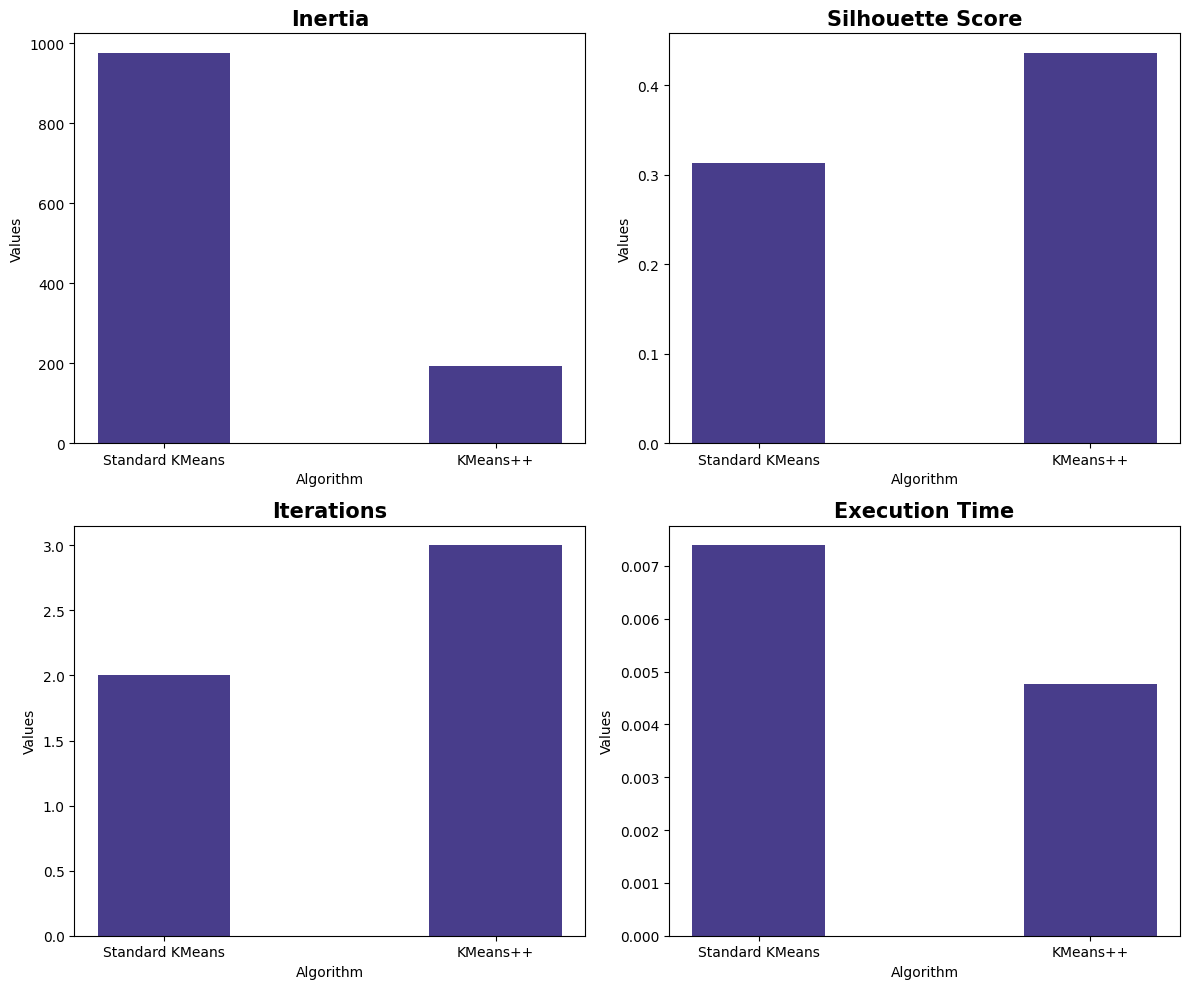

In [66]:
fig,ax=plt.subplots(2,2,figsize=(12,10))
metrics = SK_VS_KP["Metric"]
for i,ax in enumerate(ax.flatten()):
    metric= metrics[i]
    values= SK_VS_KP.loc[SK_VS_KP["Metric"] == metric].iloc[0, 1:]
    labels= ["Standard KMeans", "KMeans++"]
    ax.bar(labels, values, width=.4,color='#483D8B')
    ax.set_title(metric, fontsize=15, fontweight="bold")
    ax.set_ylabel("Values")
    ax.set_xlabel("Algorithm")
    ax.tick_params(axis="x")
    ax.tick_params(axis="y")
plt.tight_layout()
plt.show()



1.  **Interia** :

  *  Standard KMeans:
      *   Higher inertia
      *   indicates less compact clusters
  
  *  KMeans++
      *  Lower inertia
      *   Produces more compact and better-formed clusters
  
  *   conclusion: KMeans++ preforms better in minimizing inertia

2.   **Silhouette Score**

  *   Standard KMeans:
      *   Lower sihouette score
      *   Clusters are less well separated

  *   KMeans++:

      *   Higher silhouette score
      *   Clusters are more distinct and clearly separated
  
  *   Conclusion: KMeans++ results in higher cluster quality

3.   **Iterations to Converge**
  
  *   Standard KMeans:

      *   Fewer iterations

  *   KMeans++:

      *   Slightly more iterations

  *   Conclusion: Standard KMeans converges faster in steps, but not necessarily to a better solution
4.   Execution Time

  *   Standard KMeans:

      *   Slightly slower

  *   KMeans++:

      *   Slightly faster

  *   Conclusion: KMeans++ is marginally more efficient in runtime











